pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


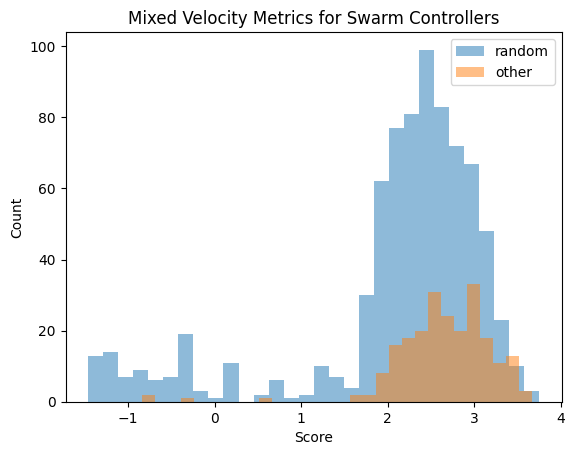

In [1]:
"""
A Script that plots the proportions of labeled class behaviors that fall within a certain magnitude.
The goal of this experiment is to determine if there is some more
"""

import torch
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import random
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

sampled_dataset = SwarmDataset("../data/full-mini", rank=0)
data = sampled_dataset

lim = 1000
controllers = []
classes = [-1 for i in range(lim)]
for i in range(lim):
    image, genome, behavior = sampled_dataset[i][0], sampled_dataset[i][1], sampled_dataset[i][2]
    for j in range(len(behavior)):
        if behavior[j] < 0.0:
            behavior[j] *= -1
    controllers.append(genome)

OUT = "../data/oracle"
with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        triplet = CSVLineToVec(line)
        classes[int(triplet[0])] = int(triplet[1])

random = []
not_random = []
for i, label in enumerate(classes):
    # Max Element Magnitude
    # mx = min(controllers[i]) if max(-min(controllers[i]), max(controllers[i])) == -min(controllers[i]) else max(controllers[i])

    # Vector Magnitude
    # mx = np.linalg.norm(controllers[i])

    # Average Element Value
    # mx = np.average(np.sqrt(np.power(controllers[i], 2)))

    # Mixing
    k = 0.5
    max_elem_score = max(-min(controllers[i]), max(controllers[i]))
    max_elem_score = -max_elem_score if max_elem_score < k else max_elem_score

    k_2 = 0.75
    magnitude_score = np.linalg.norm(controllers[i])
    magnitude_score = -magnitude_score if magnitude_score < k_2 else magnitude_score

    k_3 = 0.3
    average_score = np.average(np.sqrt(np.power(controllers[i], 2)))
    average_score = -average_score if average_score < k_3 else average_score

    mx = max_elem_score + magnitude_score + average_score

    if label == 0:
        random.append(mx)
    else:
        not_random.append(mx)

plt.hist(random, bins=30, alpha=0.5, label='random')
plt.hist(not_random, bins=30, alpha=0.5, label='other')
plt.legend(loc='upper right')
plt.title("Mixed Velocity Metrics for Swarm Controllers")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# Also try hist2d with the second largest value from each controller

# EPSILON = 0.05
# total_counts = [0 for i in range(max(classes) + 1)]
# count = [0 for i in range(max(classes) + 1)]
# for i, vec in enumerate(controllers):
#     total_counts[classes[i]] += 1
#
#     nparr = np.array(vec)
#     # if np.linalg.norm(vec) > EPSILON:
#     #     count[classes[i]] += 1
#     for l in vec:
#         if EPSILON > l > -EPSILON:
#             print(vec)
#             count[classes[i]] += 1
#             break
#
# print(total_counts, count)